## Recommender System for Airbnb Listings in Seattle

Author: Hatice K. Erdogan 

This notebook shows the steps taken to get the text data ready with Natural Language Processing techniques. The text data is first cleaned and preprocessed then vectorized with CountVectorizer, TF-IDF Vectorizer and Word2Vec and Doc2Vec. The vectorized text is then used to find similarities between the user input and the data to make recommendations. 

# Data Pre-processing 

In [1]:
# Importing relevant libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
pd.set_option("display.max_columns" , None)

The listings dataset contains 92 columns in total. However, I want my recommender to be based on text data which is name, summary, space, description, neighborhood overview, notes and transit columns of each listing, so these are the columns that will be used in Natual Language Processing. 

In [2]:
df = pd.read_csv('Data/listings.csv', usecols=['id', 'name', 'summary', 'space', 'description', 'neighborhood_overview','notes','transit', 'price', 'cancellation_policy', 'bedrooms', 'accommodates', 'room_type', 'property_type', 'neighbourhood_group_cleansed'])
df.head()

id                                 name  \
0   241032         Stylish Queen Anne Apartment   
1   953595   Bright & Airy Queen Anne Apartment   
2  3308979  New Modern House-Amazing water view   
3  7421966                   Queen Anne Chateau   
4   278830       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description  \
0  Make your self at home in this charming one-be...   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3                                                NaN   
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  \
0                                                NaN   
1  What's up with the free pillows?  Our home was...   
2  Our house is located just 5 short blocks to To...   
3                                                NaN   
4                                          Belltown    

                                             transit  \
0                                                NaN   
1  Convenient bus stops are just down the block, ...   
2  A bus stop is just 2 blocks away.   Easy bus a...   
3                                                NaN   
4  The nearest public transit bus (D Line) is 2 b...   

  neighbourhood_group_cleansed property_type        room_type  accommodates  \
0                   Queen Anne     Apartment  Entire home/apt             4   
1                   Queen Anne     Apartment  Entire home/apt             4   
2                   Queen Anne         House  Entire home/apt            11   
3                   Queen Anne     Apartment  Entire home/apt             3   
4                   Queen Anne         House  Entire home/apt             6   

   bedrooms    price cancellation_policy  
0       1.0   $85.00            moderate  
1       1.0  $150.00              strict  
2       5.0  $975.00              strict  
3       0.0  $100.00            flexible  
4       3.0  $450.00              strict

In [3]:
# 3818 listings with 15 columns describing listings' attributes, 7 columns will be used for NLP
df.shape

(3818, 15)

In [4]:
df.isna().sum()

id                                 0
name                               0
summary                          177
space                            569
description                        0
neighborhood_overview           1032
notes                           1606
transit                          934
neighbourhood_group_cleansed       0
property_type                      1
room_type                          0
accommodates                       0
bedrooms                           6
price                              0
cancellation_policy                0
dtype: int64

In [5]:
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())
df['property_type'] = df['property_type'].fillna('Apartment')
# Cleaning price column 
df['price'] = df['price'].replace('[\$,]','',regex=True).astype(float)

# Preprocess the Texts in Columns  

In [6]:
import re
import string

In [7]:
# Fill missing values with empty strings. When we combine the rows as one row for each listing, null values will have no effect. 
df['summary'] = df['summary'].fillna('')
df['space'] = df['space'].fillna('')
df['neighborhood_overview'] = df['neighborhood_overview'].fillna('')
df['notes'] = df['notes'].fillna('')
df['transit'] = df['transit'].fillna('')

In [8]:
# Creating a new column that combines all the columns with descriptions of the listings
df['content'] = df['name'] + ' ' + df['summary'] + ' ' + df['space'] + ' ' + df['description'] + ' ' + df['neighborhood_overview'] + ' ' + df['notes'] + ' ' + df['transit']
df['content'].head()

0    Stylish Queen Anne Apartment  Make your self a...
1    Bright & Airy Queen Anne Apartment Chemically ...
2    New Modern House-Amazing water view New modern...
3    Queen Anne Chateau A charming apartment that s...
4    Charming craftsman 3 bdm house Cozy family cra...
Name: content, dtype: object

In [9]:
df.head()

id                                 name  \
0   241032         Stylish Queen Anne Apartment   
1   953595   Bright & Airy Queen Anne Apartment   
2  3308979  New Modern House-Amazing water view   
3  7421966                   Queen Anne Chateau   
4   278830       Charming craftsman 3 bdm house   

                                             summary  \
0                                                      
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                      
4  Cozy family craftman house in beautiful neighb...   

                                         description  \
0  Make your self at home in this charming one-be...   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                               neighborhood_overview  \
0                                                      
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3                                                      
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  \
0                                                      
1  What's up with the free pillows?  Our home was...   
2  Our house is located just 5 short blocks to To...   
3                                                      
4                                          Belltown    

                                             transit  \
0                                                      
1  Convenient bus stops are just down the block, ...   
2  A bus stop is just 2 blocks away.   Easy bus a...   
3                                                      
4  The nearest public transit bus (D Line) is 2 b...   

  neighbourhood_group_cleansed property_type        room_type  accommodates  \
0                   Queen Anne     Apartment  Entire home/apt             4   
1                   Queen Anne     Apartment  Entire home/apt             4   
2                   Queen Anne         House  Entire home/apt            11   
3                   Queen Anne     Apartment  Entire home/apt             3   
4                   Queen Anne         House  Entire home/apt             6   

   bedrooms  price cancellation_policy  \
0       1.0   85.0            moderate   
1       1.0  150.0              strict   
2       5.0  975.0              strict   
3       0.0  100.0            flexible   
4       3.0  450.0              strict   

                                             content  
0  Stylish Queen Anne Apartment  Make your self a...  
1  Bright & Airy Queen Anne Apartment Chemically ...  
2  New Modern House-Amazing water view New modern...  
3  Queen Anne Chateau A charming apartment that s...  
4  Charming craftsman 3 bdm house Cozy family cra...

In [10]:
#df_content = df['content'].tolist()
df_content = df['content'].apply(len)
df_content

0       2034
1       3618
2       3308
3        510
4       2504
        ... 
3813    2684
3814    2056
3815     361
3816    2282
3817     606
Name: content, Length: 3818, dtype: int64

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


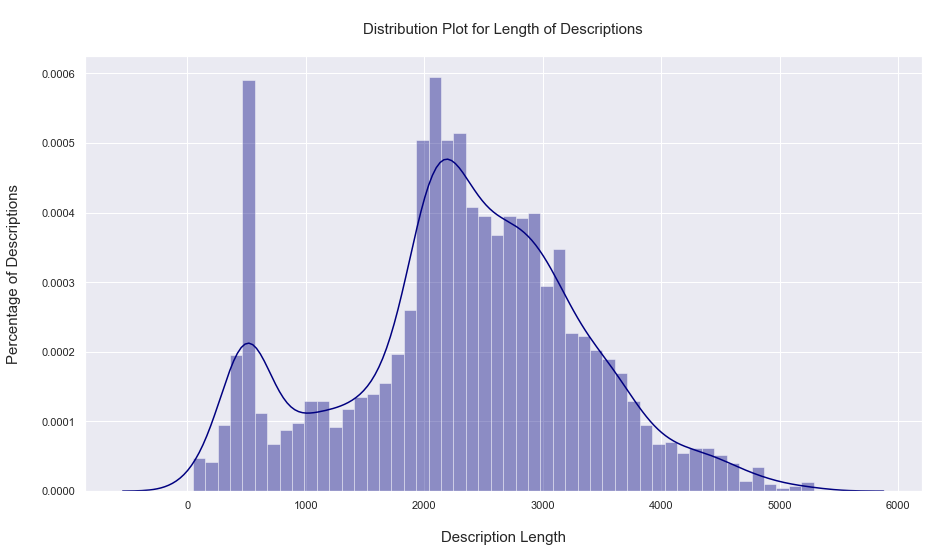

In [11]:
import seaborn as sns 
sns.set_theme(style='darkgrid')
#sns.set_color_codes('pastel')
plt.figure(figsize=(15, 8))

sns.distplot(df_content, kde=True, bins=50, color='navy')

plt.title('\nDistribution Plot for Length of Descriptions\n', fontsize=15)
plt.xlabel('\nDescription Length', fontsize=15)
plt.ylabel('Percentage of Descriptions\n', fontsize=15);

In [12]:
# Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe.
# Removing contractions to standardize text 

import contractions
expanded_words = []   
for word in df['content']:
# Using contractions.fix to expand the shortened words
  expanded_words.append(contractions.fix(word))  
   
df['content'] = expanded_words

In [13]:
df['content'][1]

"Bright & Airy Queen Anne Apartment Chemically sensitive? We have removed the irritants triggering allergy or asthma attacks, like carpeting, forced air & used pillows, all culprits that harbor fungus, mold & bacteria.  No smoking, no pets.  Designed for healthy living, so breathe easy. Beautiful, hypoallergenic apartment in an extremely safe, quiet and pedestrian-friendly section of Queen Anne.  A leafy-green location that puts the best of Seattle at your doorstep. Free WiFi, free parking, ...even free pillows!  What is special about this place? Hypo-allergenic bedding, mattresses/covers and new pillows with each rental. (So feel free to take your new pillows with you!)  A beautiful restoration mixing period details & modern sensibilities: Hardwood floors throughout, white subway tile, low/no VOCs & non-toxic paints keep this home-away-from-home clean, smart and healthy. Radiant heat and oil radiators mean no blowing hot air or dust.  Great Amenities: Free WiFi & internet TV (LED flat

In [14]:
# Creating a function that will preprocess and standardize the text for NLP 
def preprocess(text):
    ''' This function takes text to preprocess and standardize it for the purpose of NLP '''
 
    # Lowercase the text 
    text = text.str.lower()
    
    # Remove punctuations using string module with regular expression
    text = text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

    # Remove word and digits 
    #text = text.apply(lambda x: re.sub('W*dw*','', x))

    # Split string by whitespace and remoce extra whitespaces 
    text = text.apply(lambda x: x.split())

    # Remove stopwords 
    import nltk
    stopwords = nltk.corpus.stopwords.words('english')
    text = text.apply(lambda x: [word for word in x if word not in stopwords])

    # Lemmatize text to group together words with the same root or lemma
    from nltk.stem.wordnet import WordNetLemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    text = text.apply(lambda x: ' '.join(x))

    return text

In [15]:
df['content'] = preprocess(df['content'])
df['content'][1]

'bright airy queen anne apartment chemically sensitive removed irritant triggering allergy asthma attack like carpeting forced air used pillow culprit harbor fungus mold bacteria smoking pet designed healthy living breathe easy beautiful hypoallergenic apartment extremely safe quiet pedestrian friendly section queen anne leafy green location put best seattle doorstep free wifi free parking even free pillow special place hypo allergenic bedding mattress cover new pillow rental feel free take new pillow beautiful restoration mixing period detail modern sensibility hardwood floor throughout white subway tile low vocs non toxic paint keep home away home clean smart healthy radiant heat oil radiator mean blowing hot air dust great amenity free wifi internet tv led flatscreen fully equipped kitchen stainless steel appliance sink disposal large washer dryer iron ironing board hairdryer plenty storage convenient parking street best location enjoy seattle celebrated macrina bakery neighborhood 

Content column is now preprocessed and ready to be vectorized.

## Count Vectorizer 

I vectorized the words with Count Vectorizer first, then I will implement TF-IDF Vectorizer and see their differences and decide on which one will be helpful building the recommendation system. 

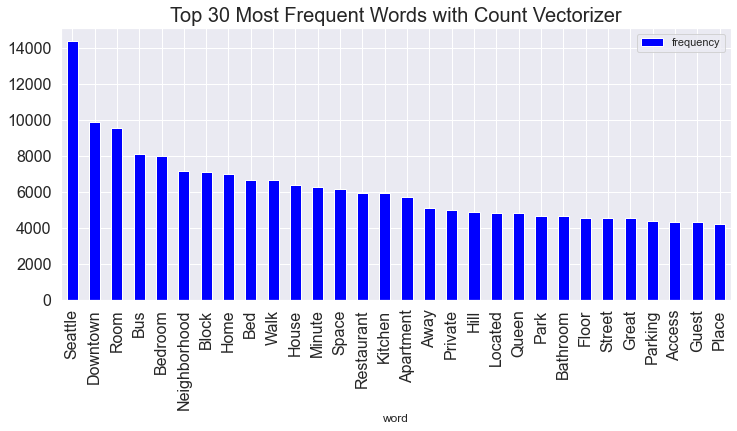

In [16]:
# Convert the content column to a matrix of word counts
# Most frequent words with Count Vectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,2))
cv_matrix = cv.fit_transform(df['content'])
cv_total = cv_matrix.sum(axis=0)

cv_freq = [(word.title(), cv_total[0, i]) for word, i in cv.vocabulary_.items()]
cv_freq = sorted(cv_freq, key = lambda x: x[1], reverse = True)
cv_frequency = pd.DataFrame(cv_freq, columns=['word', 'frequency'])

# Plotting Top 30 Most Frequent Words with CV 
cv_frequency.head(30).plot(x='word', y='frequency', kind='bar', figsize=(12, 5), color = 'blue')
plt.title('Top 30 Most Frequent Words with Count Vectorizer', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

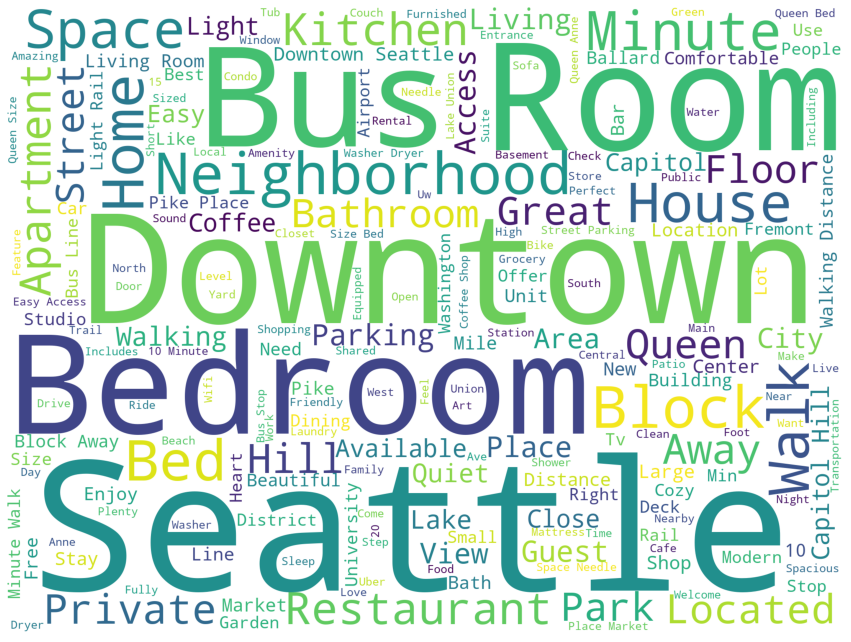

In [17]:
# Wordcloud of the words with Count Vectorizer 
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(cv_freq))
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis('off');

## Simple Recommender with Count Vectorizer 

Below is a simple recommender function with count vectorizer. It asks user to enter some characteristics of listings they are interested in. 

In [18]:
query = cv.transform(['I want an apartment in queen anne with parking'])
print(cosine_similarity(query, cv_matrix))

[[0.27502835 0.1719637  0.22501017 ... 0.02610868 0.03876559 0.21643649]]


In [19]:
similarity = cosine_similarity(query, cv_matrix)
np.argsort(similarity[0])[-5:]

array([3154,  481, 3172, 3184, 3201])

In [20]:
np.argmax(similarity[0])

3201

In [21]:
df.loc[3201]

id                                                                        7921289
name                                          Open 1 Bedroom + Balcony &City View
summary                         Enjoy your own apartment on the top of Queen A...
space                                  Open one bedroom with a balcony and views!
description                     Enjoy your own apartment on the top of Queen A...
neighborhood_overview           This apartment is located on the top of Queen ...
notes                                                                            
transit                         Downtown is a 15 minute bus ride away, bus sto...
neighbourhood_group_cleansed                                           Queen Anne
property_type                                                           Apartment
room_type                                                         Entire home/apt
accommodates                                                                    2
bedrooms        

In [22]:
def recommend_five():
    ''' This function asks the user a question and then takes in the answer to finds the top 5 similar listings '''
    
    question = input('What are some features you are interested in? ')
    inquiry = cv.transform([question])
    similarity = cosine_similarity(inquiry, cv_matrix)
    nums = np.argsort(similarity[0])[-5:]
    return df['name'].loc[nums]

In [23]:
# Recommend five listings with the answer 'free parking'
recommend_five()

416       Sweet+Cozy+Safe Studio in Seattle
845             Artistic home, free parking
866      Cozy Private Loft Apt with Balcony
1632    Private Bedroom, Bathroom,& Parking
349     Wallingford 2 Bedroom Cozy Craftman
Name: name, dtype: object

## TF-IDF Vectorizer 

TF-IDF is a method that assigns a numerical weightage of words which reflects how important the particular word is to a document in corpus. N-grams are continuous sequence of words or symbols or tokens in a document. I will vectorize the text data with TF-IDF using Unigrams, Bigrams and Trigrams and evluate the most frequent words with each ngram.

## TF-IDF Unigram

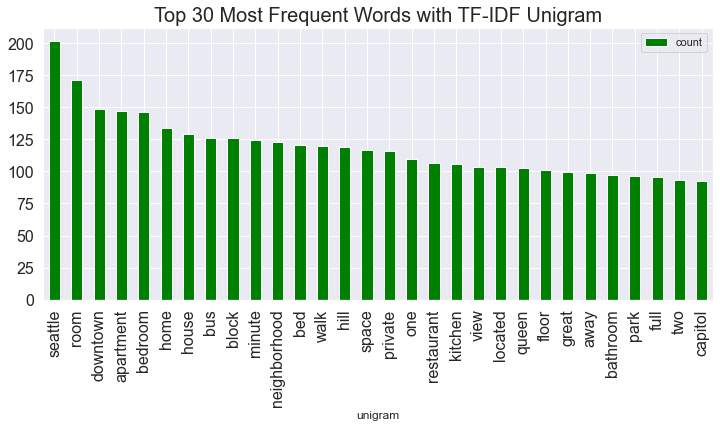

In [24]:
# Converting text descriptions into vectors using TF-IDF using Unigrams
tf = TfidfVectorizer(ngram_range=(1, 1), lowercase = False)
tf_matrix = tf.fit_transform(df['content'])
tf_total = tf_matrix.sum(axis=0) 
# Finding the word frequency
tf_freq = [(word, tf_total[0, idx]) for word, idx in tf.vocabulary_.items()]
tf_freq = sorted(tf_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
unigram = pd.DataFrame(tf_freq, columns = ['unigram', 'count'])

# Plotting the bigram distribution of top 30 words 
unigram.head(30).plot(x='unigram', y='count', kind='bar', figsize=(12, 5), color = 'green')
plt.title('Top 30 Most Frequent Words with TF-IDF Unigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

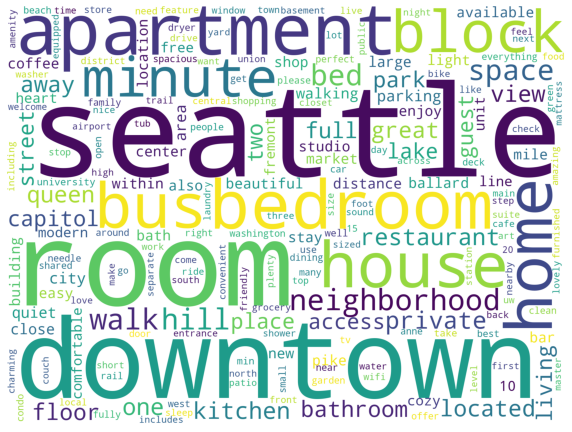

In [25]:
# Wordcloud of the words with TF-IDF Vectorizer with Unigram
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

## TF-IDF Unigram & Bigram 

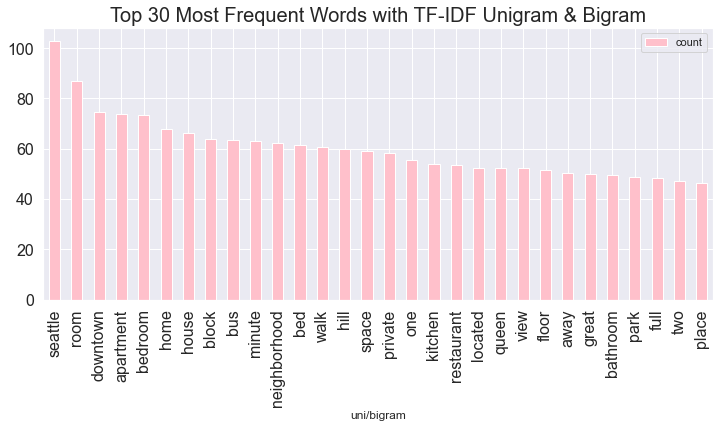

In [26]:
# Converting text descriptions into vectors using TF-IDF using Unigrams & Bigrams
tf1 = TfidfVectorizer(ngram_range=(1, 2), lowercase = False)
tf1_matrix = tf1.fit_transform(df['content'])
tf1_total = tf1_matrix.sum(axis=0) 
# Finding the word frequency
tf1_freq = [(word, tf1_total[0, idx]) for word, idx in tf1.vocabulary_.items()]
tf1_freq = sorted(tf1_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
unibigram = pd.DataFrame(tf1_freq, columns = ['uni/bigram', 'count'])

# Plotting the bigram distribution of top 30 words 
unibigram.head(30).plot(x='uni/bigram', y='count', kind='bar', figsize=(12, 5), color = 'pink')
plt.title('Top 30 Most Frequent Words with TF-IDF Unigram & Bigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

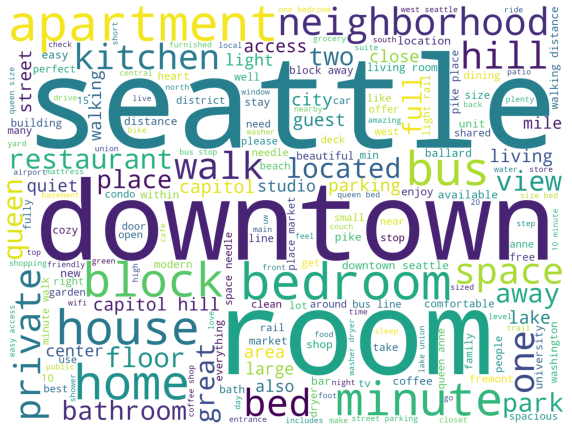

In [27]:
# Wordcloud of the words with TF-IDF Vectorizer with Unigram & Bigram
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf1_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

## TF-IDF Bigram 

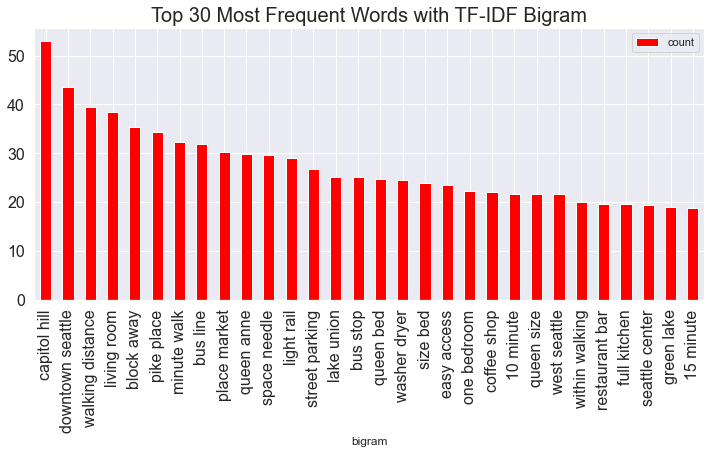

In [28]:
# Converting text descriptions into vectors using TF-IDF using Bigram
tf2 = TfidfVectorizer(ngram_range=(2, 2), lowercase = False)
tf2_matrix = tf2.fit_transform(df['content'])
tf2_total = tf2_matrix.sum(axis=0) 
# Finding the word frequency
tf2_freq = [(word, tf2_total[0, idx]) for word, idx in tf2.vocabulary_.items()]
tf2_freq = sorted(tf2_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
bigram = pd.DataFrame(tf2_freq, columns = ['bigram', 'count'])

# Plotting the bigram distribution of top 30 words 
bigram.head(30).plot(x='bigram', y='count', kind='bar', figsize=(12, 5), color = 'red')
plt.title('Top 30 Most Frequent Words with TF-IDF Bigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

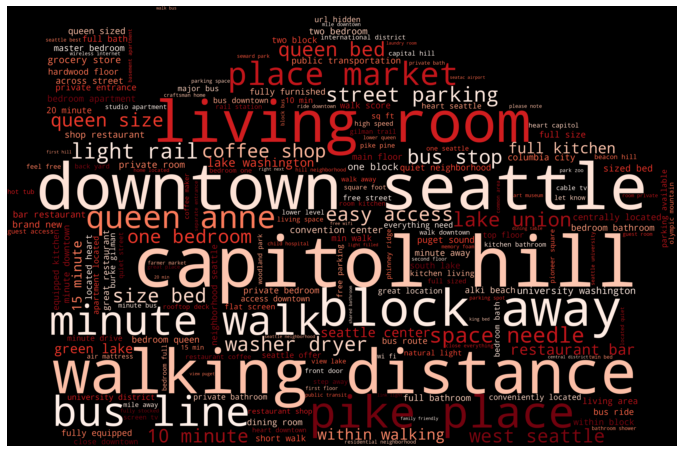

In [30]:
# Word cloud with TF-IDF Bigram in House Shape
from PIL import Image
from wordcloud import ImageColorGenerator
house_mask = np.array(Image.open("Images/house.png"))

wordcloud = WordCloud(width=1000, height=1000, background_color="black", mask=house_mask, colormap='Reds_r', 
stopwords=["size bed", "queen size"], random_state=1, contour_width=0, contour_color=None).generate_from_frequencies(dict(tf2_freq))

plt.figure(figsize=[12, 12])
plt.imshow(wordcloud, interpolation='bilinear')
#plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

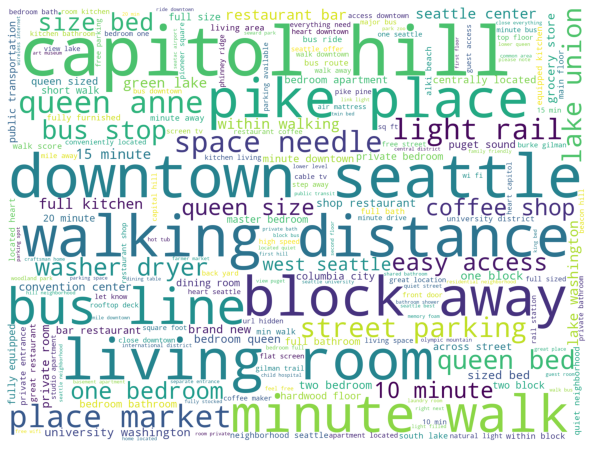

In [31]:
# Wordcloud of the words with TF-IDF Vectorizer with Bigram
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf2_freq))
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud)
plt.axis('off');

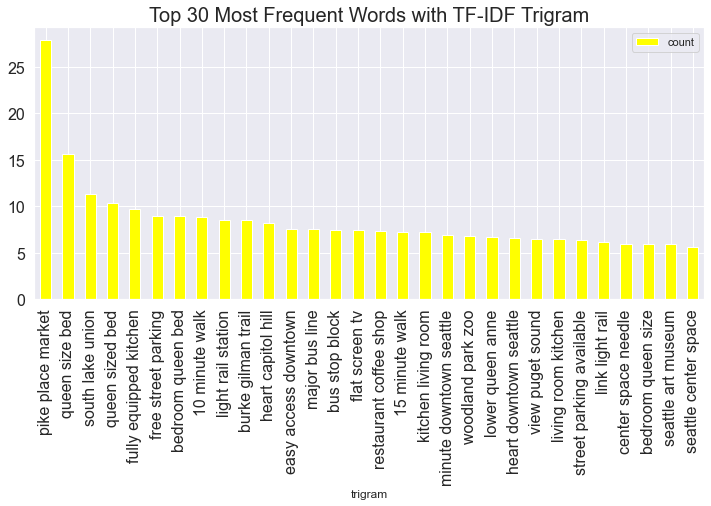

In [32]:
# Converting text descriptions into vectors using TF-IDF using Trigram
tf3 = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tf3_matrix = tf3.fit_transform(df['content'])
tf3_total = tf3_matrix.sum(axis=0) 

# Finding the word frequency
tf3_freq = [(word, tf3_total[0, idx]) for word, idx in tf3.vocabulary_.items()]
tf3_freq =sorted(tf3_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
trigram = pd.DataFrame(tf3_freq, columns = ['trigram', 'count'])

# Plotting the trigram distribution of top 30 words 
trigram.head(30).plot(x='trigram', y='count', kind='bar', figsize=(12, 5), color = 'yellow')
plt.title('Top 30 Most Frequent Words with TF-IDF Trigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

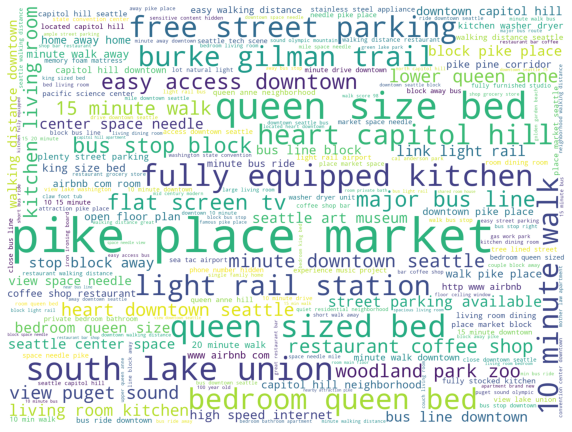

In [33]:
# Wordcloud of the words with TF-IDF Vectorizer with Trigram
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf3_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

## Recommender System with TF-IDF 

I will be using cosine similarity to calculate the similarity between listings with bigram TF-IDF vectorizer because single words do not have much meaning.  

In [34]:
def recommend(content):
    inquiry = tf2.transform([content])
    similarity = cosine_similarity(inquiry, tf2_matrix)
    nums = np.argsort(similarity[0])[-5:]
    return df['name'].loc[nums]

In [35]:
recommend('pool')

1278     Downtown 2Bed Western Sunset Views
1279             Penthouse Suite Top Floor 
1280    Luxury Studio with Amazing Views 24
1268         Downtown, Great Amenities! V62
3817              Large Lakefront Apartment
Name: name, dtype: object

In [36]:
recommend('free parking three bedroom downtown seattle')

31         Queen Anne 3 bed near everything
2120               Beacon Hill Private Room
1843         Three  bedroom home in Ballard
527     Amazing Huge Modern Green Lake Home
489               3 bedroom Queen Anne Home
Name: name, dtype: object

In [37]:
recommend('free parking pike place market coffee shop 2 bedroom')

1489    Pike Place 2 Blocks, Best Spot! HS2
1466          Pike's Place 1Bed Sunset View
1547      1 Block to PIKE PLACE MARKET! HS2
2330              Seward Park Mother In Law
3172          Spacious Queen Anne townhouse
Name: name, dtype: object

In [38]:
# Comparing each lisitng with every other listing in the dataset
# Each row and each column is a listing from the dataset
cosine_similarity(tf2_matrix)

array([[1.00000000e+00, 2.69345271e-02, 2.16299122e-02, ...,
        7.43343506e-03, 1.04797802e-02, 1.24981747e-02],
       [2.69345271e-02, 1.00000000e+00, 1.44928429e-02, ...,
        0.00000000e+00, 8.08366676e-03, 1.08406084e-02],
       [2.16299122e-02, 1.44928429e-02, 1.00000000e+00, ...,
        0.00000000e+00, 8.80300167e-04, 1.21051460e-02],
       ...,
       [7.43343506e-03, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 4.55255274e-02, 0.00000000e+00],
       [1.04797802e-02, 8.08366676e-03, 8.80300167e-04, ...,
        4.55255274e-02, 1.00000000e+00, 1.72324911e-02],
       [1.24981747e-02, 1.08406084e-02, 1.21051460e-02, ...,
        0.00000000e+00, 1.72324911e-02, 1.00000000e+00]])

In [39]:
# Using an ngram range 1 through 3, so we can use words which contain up to 4 continuous sequence of words or tokens
tfidf_rec = TfidfVectorizer(ngram_range=(1, 3), lowercase = False)
tfidf_matrix = tfidf_rec.fit_transform(df['content'])
cosine_sim = linear_kernel(tfidf_matrix)

In [40]:
def recommend(content):
	similarity = linear_kernel(tfidf_rec.transform(np.array([content])), tfidf_matrix)
	nums = np.argsort(similarity[0])[-5:]
	return df['name'].loc[nums]

In [41]:
recommend('free parking queen anne')

454     Newly Renovated Queen Anne 2 Bdrm
3172        Spacious Queen Anne townhouse
216      Top of Queen Anne 3 Bed / 2 Bath
31       Queen Anne 3 bed near everything
21      Cozy Queen Anne Finished Basement
Name: name, dtype: object

The recommender performs well on recommending top 5 similar listings in Queen Anne with free parking.

# Word Embeddings 

### Word2Vec 

In [42]:
from gensim.models import Word2Vec 
from nltk import word_tokenize
df['content_w2v'] = df['name'] + ' ' + df['summary'] + ' ' + df['space'] + ' ' + df['description'] + ' ' + df['neighborhood_overview'] + ' ' + df['notes'] + ' ' + df['transit']
data = df['content_w2v'].map(word_tokenize)

In [43]:
data

0       [Stylish, Queen, Anne, Apartment, Make, your, ...
1       [Bright, &, Airy, Queen, Anne, Apartment, Chem...
2       [New, Modern, House-Amazing, water, view, New,...
3       [Queen, Anne, Chateau, A, charming, apartment,...
4       [Charming, craftsman, 3, bdm, house, Cozy, fam...
                              ...                        
3813    [3BR, Mountain, View, House, in, Seattle, Our,...
3814    [Portage, Bay, View, !, -One, Bedroom, Apt, 80...
3815    [Private, apartment, view, of, Lake, WA, Very,...
3816    [Amazing, View, with, Modern, Comfort, !, Cozy...
3817    [Large, Lakefront, Apartment, All, hardwood, f...
Name: content_w2v, Length: 3818, dtype: object

In [45]:
data = data.apply(lambda x:[word.lower() for word in x])
data

0       [stylish, queen, anne, apartment, make, your, ...
1       [bright, &, airy, queen, anne, apartment, chem...
2       [new, modern, house-amazing, water, view, new,...
3       [queen, anne, chateau, a, charming, apartment,...
4       [charming, craftsman, 3, bdm, house, cozy, fam...
                              ...                        
3813    [3br, mountain, view, house, in, seattle, our,...
3814    [portage, bay, view, !, -one, bedroom, apt, 80...
3815    [private, apartment, view, of, lake, wa, very,...
3816    [amazing, view, with, modern, comfort, !, cozy...
3817    [large, lakefront, apartment, all, hardwood, f...
Name: content_w2v, Length: 3818, dtype: object

In [46]:
# Training listing content with Word2Vec model
model = Word2Vec(data, size = 100, window = 5, min_count = 5, workers = 4)
model.train(data, total_examples = model.corpus_count, epochs = 10 )

(12405698, 17568190)

In [47]:
wv = model.wv

In [48]:
wv.most_similar('parking')

[('free-parking', 0.49805396795272827),
 ('fragrance', 0.4813106060028076),
 ('gluten', 0.43194273114204407),
 ('fairs', 0.42098116874694824),
 ('readily', 0.40461266040802),
 ('driveway', 0.4045338034629822),
 ('-parking', 0.39932703971862793),
 ('blanchard', 0.39245304465293884),
 ('parked', 0.39208441972732544),
 ('dead-end', 0.3829387426376343)]

### Doc2Vec

In [149]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# Tokenization of each description 
tokenized_doc = []
for d in df['content']:
    tokenized_doc.append(word_tokenize(d.lower()))
tokenized_doc


[['stylish',
  'queen',
  'anne',
  'apartment',
  'make',
  'self',
  'home',
  'charming',
  'one',
  'bedroom',
  'apartment',
  'centrally',
  'located',
  'west',
  'side',
  'queen',
  'anne',
  'hill',
  'elegantly',
  'decorated',
  'completely',
  'private',
  'apartment',
  'bottom',
  'unit',
  'duplex',
  'open',
  'floor',
  'plan',
  'bamboo',
  'floor',
  'fully',
  'equipped',
  'kitchen',
  'tv',
  'dvd',
  'player',
  'basic',
  'cable',
  'cozy',
  'bedroom',
  'queen',
  'size',
  'bed',
  'unit',
  'sleep',
  'four',
  'two',
  'bedroom',
  'two',
  'comfortable',
  'fold',
  'couch',
  'linen',
  'included',
  'includes',
  'free',
  'wifi',
  'laundry',
  'apartment',
  'open',
  'onto',
  'private',
  'deck',
  'complete',
  'bbq',
  'overlooking',
  'garden',
  'forest',
  'black',
  'bamboo',
  'apartment',
  'perfectly',
  'located',
  'one',
  'block',
  'bus',
  'line',
  'catch',
  'bus',
  'downtown',
  'seattle',
  'fifteen',
  'minute',
  'historic',
  

In [151]:
# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]

In [153]:
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)
# Save trained doc2vec model
model.save("test_doc2vec.model")
## Load saved doc2vec model
model= Doc2Vec.load("test_doc2vec.model")
## Print model vocabulary
model.wv.vocab

{'stylish': <gensim.models.keyedvectors.Vocab at 0x175fdc280>,
 'queen': <gensim.models.keyedvectors.Vocab at 0x19eb91e20>,
 'anne': <gensim.models.keyedvectors.Vocab at 0x19eb91df0>,
 'apartment': <gensim.models.keyedvectors.Vocab at 0x19eb91e80>,
 'make': <gensim.models.keyedvectors.Vocab at 0x19eb91fd0>,
 'self': <gensim.models.keyedvectors.Vocab at 0x19eb91fa0>,
 'home': <gensim.models.keyedvectors.Vocab at 0x19eca8040>,
 'charming': <gensim.models.keyedvectors.Vocab at 0x19eca80a0>,
 'one': <gensim.models.keyedvectors.Vocab at 0x19eca8100>,
 'bedroom': <gensim.models.keyedvectors.Vocab at 0x19eca8160>,
 'centrally': <gensim.models.keyedvectors.Vocab at 0x19eca81c0>,
 'located': <gensim.models.keyedvectors.Vocab at 0x19eca8220>,
 'west': <gensim.models.keyedvectors.Vocab at 0x19eca8280>,
 'side': <gensim.models.keyedvectors.Vocab at 0x19eca82e0>,
 'hill': <gensim.models.keyedvectors.Vocab at 0x19eca8340>,
 'elegantly': <gensim.models.keyedvectors.Vocab at 0x19eca83a0>,
 'decorated'

In [154]:
# Find top 5 similar doc 
test_doc = word_tokenize("two bedroom queen anne apartment".lower())
model.docvecs.most_similar(positive=[model.infer_vector(test_doc)],topn=5)

[(1821, 0.8587163686752319),
 (3279, 0.8398610353469849),
 (1057, 0.8306090831756592),
 (874, 0.8231253623962402),
 (598, 0.8198035955429077)]

In [158]:
df['content'][3279]

'hotellike full kitchen parking enjoy pacific nw apartment reclaimed hardwood floor new carpet granite kitchen bath tile flooring throughout main area clean warm cozy private deck wood burning fireplace plush linen pillow close e line downtown seattle local neighborhood entire space privacy dedicated parking spot vehicle leave car take bus choose hire professional staffing clean unit guest visit every area place guest touch sanitized cleaned safety cleanliness peace mind stay u sheet linen laundered every time guest leaf oaktree suite 3rd level wood burning fireplace outside deck facing south kitchen full appliance stay blender salad spinner toaster microwave coffee maker rice cooker lot pot pan cooking utensil pizza cutter knife etc free wifi selected dvd movie travel book chromecast 50 tv channel special request need please ask try best accommodate request go thing get h enjoy pacific nw apartment reclaimed hardwood floor new carpet granite kitchen bath tile flooring throughout main 